In [1]:
# Imports and environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
plt.style.use('ggplot')

import math
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , mean_squared_error , accuracy_score
# Custom utils functions
from Utils.Helper import impute_outliers_iqr, cap_outliers_iqr, plot_confusion_matrices,print_evaluation_metrics,plot_hyperparameter_tuning_results
# from utils.visualization import visualize_training

## Extract data from csv file.

In [2]:
df_train = pd.read_csv("data_train.csv",delimiter=',')

In [3]:
print(df_train)

            Id  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0            0       0         0          1   24       1       0   
1            1       0         0          1   28       0       0   
2            2       0         0          1   36       1       0   
3            3       0         1          1   35       0       0   
4            4       0         1          1   27       0       0   
...        ...     ...       ...        ...  ...     ...     ...   
202939  202939       0         0          1   29       0       0   
202940  202940       0         0          1   23       0       0   
202941  202941       1         1          1   38       0       0   
202942  202942       0         1          1   22       0       0   
202943  202943       0         0          1   22       0       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...  MentHlth  PhysHlth  \
0                          0             1       0  ...         0         0   
1                        

In [4]:
print(df_train.isna().sum())

Id                      0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
ExtraMedTest            0
ExtraAlcoholTest        0
Status                  0
dtype: int64


### Process Data - Drop out the feature Id in training set 

In [5]:
df_train = df_train.drop(['Id'],axis=1)

Drop out the feature that has the absolute value less than 0.05

In [6]:
corr_matrix = df_train.corr()

# Get the correlation values with the target column
target_corr = corr_matrix["Status"]
threshold = 0.05
# Drop columns with correlation values insinde the threshold range
columns_to_drop = target_corr[(target_corr >= -threshold) & (target_corr <= threshold)].index
df_train.drop(columns=columns_to_drop, inplace=True)
print(columns_to_drop)
df_train.info()

Index(['Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
       'NoDocbcCost', 'Sex'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202944 entries, 0 to 202943
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                202944 non-null  int64
 1   HighChol              202944 non-null  int64
 2   CholCheck             202944 non-null  int64
 3   BMI                   202944 non-null  int64
 4   Smoker                202944 non-null  int64
 5   Stroke                202944 non-null  int64
 6   HeartDiseaseorAttack  202944 non-null  int64
 7   PhysActivity          202944 non-null  int64
 8   GenHlth               202944 non-null  int64
 9   MentHlth              202944 non-null  int64
 10  PhysHlth              202944 non-null  int64
 11  DiffWalk              202944 non-null  int64
 12  Age                   202944 non-null  int64
 13  Education       

In [7]:
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

In [8]:
train_x, val_x, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2
)

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {val_x.shape}")
print(f"test_y shape: {val_y.shape}")

train_x shape: (162355, 17)
train_y shape: (162355, 1)
test_X shape: (40589, 17)
test_y shape: (40589, 1)


## Preprocessed Data

In [9]:
# Initialize lists to store column names
classification_cols = []
continuous_cols = []

# Loop through each column
for col in df_train.columns:
    # Check if the column has less than 30 unique values( the max scale is 30)
    if df_train[col].nunique() <= 30:
        classification_cols.append(col)
    # Check if the column has more than 30 unique values (continuous)
    elif df_train[col].nunique() > 35:
        continuous_cols.append(col)

# Print identified binary and continuous columns
print("Classification Columns:", classification_cols)
print("Continuous Columns:", continuous_cols)

Classification Columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'DiffWalk', 'Age', 'Education', 'Income', 'Status']
Continuous Columns: ['BMI', 'ExtraMedTest', 'ExtraAlcoholTest']


In [10]:
from sklearn.preprocessing import PowerTransformer

# Columns to be scaled
columns_to_scale = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'ExtraMedTest', 'ExtraAlcoholTest']

# Initialize PowerTransformer
powerTransformer = PowerTransformer(method = 'yeo-johnson',standardize = False)

train_x[columns_to_scale] = powerTransformer.fit_transform(train_x[columns_to_scale])
val_x[columns_to_scale] = powerTransformer.transform(val_x[columns_to_scale])

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler(random_state=0)

# Apply undersampling to the training data
train_x_balanced, train_y_balanced = undersampler.fit_resample(train_x, train_y)

## Logistic Regression Linear Features with Preprocess Data

In [12]:
baseline_clf = LogisticRegression(
    penalty=None,             # No regularization
    class_weight="balanced",# Because our training data is imbalanced
    max_iter=2000,
    random_state=0          # Reproducible result
)

In [13]:
# Train the baseline classifier on the balanced training set
baseline_clf.fit(train_x_balanced, train_y_balanced.values.ravel())
# Save the trained model to a file
dump(baseline_clf, "./Model/logisticRegBase.joblib")
print("Model saved successfully.")

Model saved successfully.


In [14]:
# Load the saved model from file
logisticRegBase = load("./Model/logisticRegBase.joblib")
# Predict Value
train_pred_y = logisticRegBase.predict(train_x_balanced)
val_pred_y = logisticRegBase.predict(val_x)

train_proba_pred_y = logisticRegBase.predict_proba(train_x_balanced)[:, 1]
val_proba_pred_y= logisticRegBase.predict_proba(val_x)[:, 1]


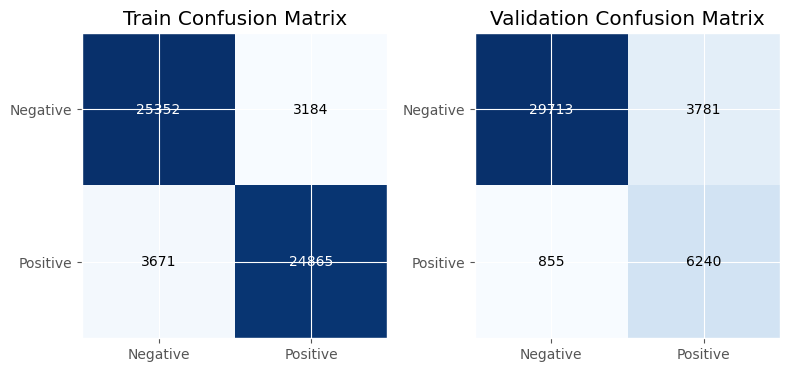

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     28536
           1       0.89      0.87      0.88     28536

    accuracy                           0.88     57072
   macro avg       0.88      0.88      0.88     57072
weighted avg       0.88      0.88      0.88     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     33494
           1       0.62      0.88      0.73      7095

    accuracy                           0.89     40589
   macro avg       0.80      0.88      0.83     40589
weighted avg       0.91      0.89      0.89     40589



In [15]:
# Print performance reports
plot_confusion_matrices(train_y_balanced,train_pred_y,val_y,val_pred_y, "Model Performance\nLogistic Regression With Normalized - Degree 1", "./Image/ModelDev_Logistic1_CM.png")

In [16]:
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Training Set:
F1 Score: 0.878854820182027
ROC AUC Score: 0.9504540271442056

Validation Set:
F1 Score: 0.7291423229726572
ROC AUC Score: 0.9519050312798863

Root Mean Squared Error : 0.3379617403185465


## Hypertuning Logistic Regression - Baseline Model

Logistic regression classifier with settings optimized for small datasets, balanced class weights, a maximum of 200 iterations for convergence, and reproducible results.

In [17]:
clf = LogisticRegression(
    solver="liblinear",       # Good for our small dataset
    class_weight="balanced",
    max_iter=200,
    random_state=0            # Reproducible result
)

The params dictionary contains hyperparameters for tuning a logistic regression model using grid search or randomized search cross-validation

In [18]:
params = {
    "C": 1 / np.logspace(-3, 2, num=15),
    "penalty": ["l1", "l2"]
}

This KFold splitter object will be used for cross-validation, where the dataset will be split into 4 folds, with the data shuffled randomly before splitting, and the random seed set to 0 for reproducibility of results.

In [19]:
cv = KFold(
    n_splits=4,     # Each fold is 20% of df_X
    shuffle=True,
    random_state=0  # Reproducible result
)

In [20]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_x_balanced, train_y_balanced.values.ravel())

GridSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', max_iter=200,
                                          random_state=0, solver='liblinear'),
             param_grid={'C': array([1.00000000e+03, 4.39397056e+02, 1.93069773e+02, 8.48342898e+01,
       3.72759372e+01, 1.63789371e+01, 7.19685673e+00, 3.16227766e+00,
       1.38949549e+00, 6.10540230e-01, 2.68269580e-01, 1.17876863e-01,
       5.17947468e-02, 2.27584593e-02, 1.00000000e-02]),
                         'penalty': ['l1', 'l2']},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [21]:
dump(grid_clf, "./Model/logisticRegBaseWithTuning.joblib")
print("Model saved successfully.")

Model saved successfully.


In [22]:
# Load the saved model from file
logistic_reg_model_tuning = load("./Model/logisticRegBaseWithTuning.joblib")
# Predict Value
train_pred_y = logistic_reg_model_tuning.predict(train_x_balanced)
val_pred_y = logistic_reg_model_tuning.predict(val_x)

train_proba_pred_y = logistic_reg_model_tuning.predict_proba(train_x_balanced)[:, 1]
val_proba_pred_y= logistic_reg_model_tuning.predict_proba(val_x)[:, 1]

In [23]:
logistic_reg_model_tuning.best_params_

{'C': 0.6105402296585326, 'penalty': 'l2'}

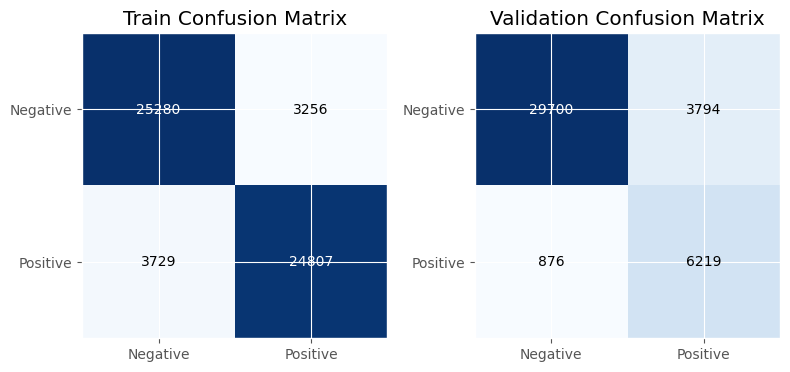

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     28536
           1       0.88      0.87      0.88     28536

    accuracy                           0.88     57072
   macro avg       0.88      0.88      0.88     57072
weighted avg       0.88      0.88      0.88     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     33494
           1       0.62      0.88      0.73      7095

    accuracy                           0.88     40589
   macro avg       0.80      0.88      0.83     40589
weighted avg       0.91      0.88      0.89     40589



In [24]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_Logistic_Tuning_CM.png")

In [25]:
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Training Set:
F1 Score: 0.876587925581724
ROC AUC Score: 0.9488421596662676

Validation Set:
F1 Score: 0.7270282908580781
ROC AUC Score: 0.9502146629987644

Root Mean Squared Error : 0.33919876664937865


 After tuning hyperparameter, the F1 score of the baseline is slightly improved!

### Logistic Polynominal With 2 degree

In [26]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(2)
train_x_poly2 = poly.fit_transform(train_x_balanced)
val_X_poly2 = poly.transform(val_x)
#Using StandardScaler 
scaler = StandardScaler()
train_x_poly2 = scaler.fit_transform(train_x_poly2)
val_X_poly2 = scaler.transform(val_X_poly2)

In [27]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True, n_jobs = -1)
grid_clf.fit(train_x_poly2, train_y_balanced.values.ravel())

GridSearchCV(cv=KFold(n_splits=4, random_state=0, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', max_iter=200,
                                          random_state=0, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e+03, 4.39397056e+02, 1.93069773e+02, 8.48342898e+01,
       3.72759372e+01, 1.63789371e+01, 7.19685673e+00, 3.16227766e+00,
       1.38949549e+00, 6.10540230e-01, 2.68269580e-01, 1.17876863e-01,
       5.17947468e-02, 2.27584593e-02, 1.00000000e-02]),
                         'penalty': ['l1', 'l2']},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [28]:
dump(grid_clf, "./Model/logisticRegPoly2WithTuning.joblib")
print("Model saved successfully.")

Model saved successfully.


In [29]:
# Load the saved model from file
poly_degree_2_model = load("./Model/logisticRegPoly2WithTuning.joblib")
# Predict Value
train_pred_y = poly_degree_2_model.predict(train_x_poly2)
val_pred_y = poly_degree_2_model.predict(val_X_poly2)

train_proba_pred_y = poly_degree_2_model.predict_proba(train_x_poly2)[:, 1]
val_proba_pred_y= poly_degree_2_model.predict_proba(val_X_poly2)[:, 1]

In [30]:
poly_degree_2_model.best_params_

{'C': 84.83428982440721, 'penalty': 'l2'}

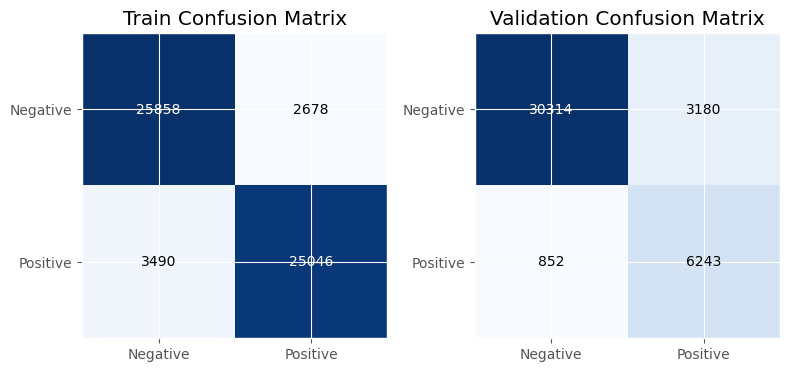

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     28536
           1       0.90      0.88      0.89     28536

    accuracy                           0.89     57072
   macro avg       0.89      0.89      0.89     57072
weighted avg       0.89      0.89      0.89     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     33494
           1       0.66      0.88      0.76      7095

    accuracy                           0.90     40589
   macro avg       0.82      0.89      0.85     40589
weighted avg       0.92      0.90      0.91     40589



In [31]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_Logistic_Poly2_Tuning_CM.png")

In [32]:
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Training Set:
F1 Score: 0.8903661571276218
ROC AUC Score: 0.9560703607909748

Validation Set:
F1 Score: 0.7559026516527424
ROC AUC Score: 0.956680373538235

Root Mean Squared Error : 0.31517813830156244


### Logistis Regression - Degree 3

In [33]:
# Degree 3 Polynomial Features:
poly = PolynomialFeatures(3)
train_x_poly3 = poly.fit_transform(train_x_balanced)
val_X_poly3 = poly.transform(val_x)

scaler = StandardScaler()
train_x_poly3 = scaler.fit_transform(train_x_poly3)
val_X_poly3 = scaler.transform(val_X_poly3)

In [34]:
params = {
    "C": 1 / np.logspace(-3, 2, num=4),
    "penalty": ["l1", "l2"]
}

In [35]:
clf = LogisticRegression(
    solver="liblinear",       # Good for our small dataset
    class_weight="balanced",
    max_iter=100,
    random_state=0            # Reproducible result
)

In [ ]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_x_poly3, train_y_balanced.values.ravel())
dump(grid_clf, "./Model/logisticRegPoly3WithTuning.joblib")
print("Model saved successfully.")

In [36]:
# Load the saved model from file
poly_degree_3_model = load("./Model/logisticRegPoly3WithTuning.joblib")
# Predict Value
train_pred_y = poly_degree_3_model.predict(train_x_poly3)
val_pred_y = poly_degree_3_model.predict(val_X_poly3)

train_proba_pred_y = poly_degree_3_model.predict_proba(train_x_poly3)[:, 1]
val_proba_pred_y= poly_degree_3_model.predict_proba(val_X_poly3)[:, 1]

In [37]:
poly_degree_3_model.best_params_

{'C': 0.01, 'penalty': 'l2'}

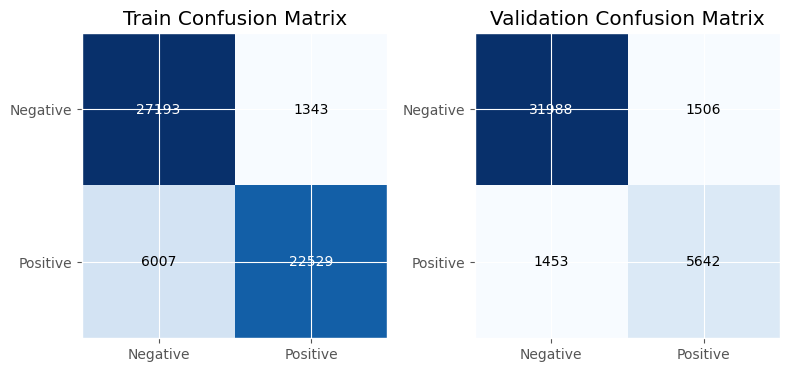

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     28536
           1       0.94      0.79      0.86     28536

    accuracy                           0.87     57072
   macro avg       0.88      0.87      0.87     57072
weighted avg       0.88      0.87      0.87     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     33494
           1       0.79      0.80      0.79      7095

    accuracy                           0.93     40589
   macro avg       0.87      0.88      0.87     40589
weighted avg       0.93      0.93      0.93     40589



In [38]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_Logistic_Poly3_Tuning_CM.png")

In [39]:
print("Logistic Regression Polynominal 3")
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Logistic Regression Polynominal 3
Training Set:
F1 Score: 0.8597542359945046
ROC AUC Score: 0.9470983806505433

Validation Set:
F1 Score: 0.7922488239837114
ROC AUC Score: 0.9480900537211908

Root Mean Squared Error : 0.2700028241402876


### Decision Tree

In [40]:
from sklearn import tree

params = {
    'max_depth': np.arange(2, 50, 5),
    'min_samples_split': np.arange(2, 50, 5)
}

In [41]:
clf = DecisionTreeClassifier(
    criterion="gini",         # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0            # Reproducible result
)


In [42]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True,n_jobs=-2)
grid_clf.fit(train_x_balanced, train_y_balanced.values.ravel())
tree_classifier = grid_clf
dump(grid_clf, "./Model/DecisionTreeWithTuning.joblib")
print("Model saved successfully.")

Model saved successfully.


In [43]:
# Load the saved model from file
decision_tree_model = load("./Model/DecisionTreeWithTuning.joblib")
# Predict Value
train_pred_y = decision_tree_model.predict(train_x_balanced)
val_pred_y = decision_tree_model.predict(val_x)

train_proba_pred_y = decision_tree_model.predict_proba(train_x_balanced)[:, 1]
val_proba_pred_y= decision_tree_model.predict_proba(val_x)[:, 1]

In [44]:
decision_tree_model.best_params_

{'max_depth': 7, 'min_samples_split': 27}

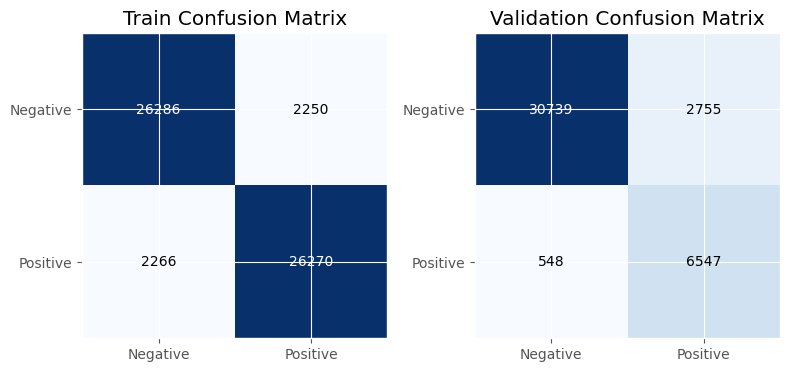

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     28536
           1       0.92      0.92      0.92     28536

    accuracy                           0.92     57072
   macro avg       0.92      0.92      0.92     57072
weighted avg       0.92      0.92      0.92     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     33494
           1       0.70      0.92      0.80      7095

    accuracy                           0.92     40589
   macro avg       0.84      0.92      0.87     40589
weighted avg       0.93      0.92      0.92     40589



In [45]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_Decision_Tree_Tuning_CM.png")

In [46]:
print("Decision Tree Model")
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Decision Tree Model
Training Set:
F1 Score: 0.9208496915311274
ROC AUC Score: 0.9802269282476292

Validation Set:
F1 Score: 0.7985607123254255
ROC AUC Score: 0.9798170219121003

Root Mean Squared Error : 0.28526606472702065


## Bagged Tree

In [47]:
params = {
    "n_estimators": np.arange(5, 15, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}


In [48]:
clf = BaggingClassifier(
    estimator= tree_classifier.best_estimator_,
    random_state=42,  # Reproducible result
)

In [49]:
grid_clf = GridSearchCV(clf, params, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True,n_jobs=-1)
grid_clf.fit(train_x_balanced, train_y_balanced.values.ravel())
dump(grid_clf, "./Model/BaggedTreeWithTuning.joblib")
print("Model saved successfully.")

Model saved successfully.


In [50]:
# Load the saved model from file
bagged_tree_model = load("./Model/BaggedTreeWithTuning.joblib")
# Predict Value
train_pred_y = bagged_tree_model.predict(train_x_balanced)
val_pred_y = bagged_tree_model.predict(val_x)

train_proba_pred_y = bagged_tree_model.predict_proba(train_x_balanced)[:, 1]
val_proba_pred_y= bagged_tree_model.predict_proba(val_x)[:, 1]

In [51]:
bagged_tree_model.best_params_

{'max_samples': 0.4, 'n_estimators': 5}

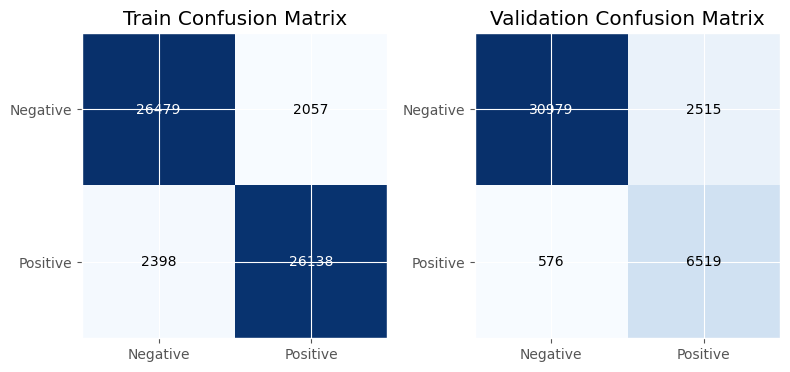

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     28536
           1       0.93      0.92      0.92     28536

    accuracy                           0.92     57072
   macro avg       0.92      0.92      0.92     57072
weighted avg       0.92      0.92      0.92     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     33494
           1       0.72      0.92      0.81      7095

    accuracy                           0.92     40589
   macro avg       0.85      0.92      0.88     40589
weighted avg       0.94      0.92      0.93     40589



In [52]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_BaggedTree_Tuning_CM.png")

In [53]:
print("Bagged Tree")
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Bagged Tree
Training Set:
F1 Score: 0.9214715058786201
ROC AUC Score: 0.9810838466752319

Validation Set:
F1 Score: 0.8083576167152335
ROC AUC Score: 0.9809406209638254

Root Mean Squared Error : 0.2759594855863576


#### Random Forest

In [54]:
params = {
    "n_estimators": np.arange(5, 100, 5),
    "max_depth": np.arange(2, 16, 2),
}

In [55]:
clf = RandomForestClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=42     # Reproducible result
)

In [56]:
grid_clf = GridSearchCV(clf, params, cv=cv, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True,n_jobs=-1)
grid_clf.fit(train_x_balanced, train_y_balanced.values.ravel())
dump(grid_clf, "./Model/RandomForestModelWithTuning.joblib")
print("Model saved successfully.")

Model saved successfully.


In [57]:
# Load the saved model from file
random_forest_model = load("./Model/RandomForestModelWithTuning.joblib")
# Predict Value
train_pred_y = random_forest_model.predict(train_x_balanced)
val_pred_y = random_forest_model.predict(val_x)

train_proba_pred_y = random_forest_model.predict_proba(train_x_balanced)[:, 1]
val_proba_pred_y= random_forest_model.predict_proba(val_x)[:, 1]

In [58]:
random_forest_model.best_params_

{'max_depth': 12, 'n_estimators': 75}

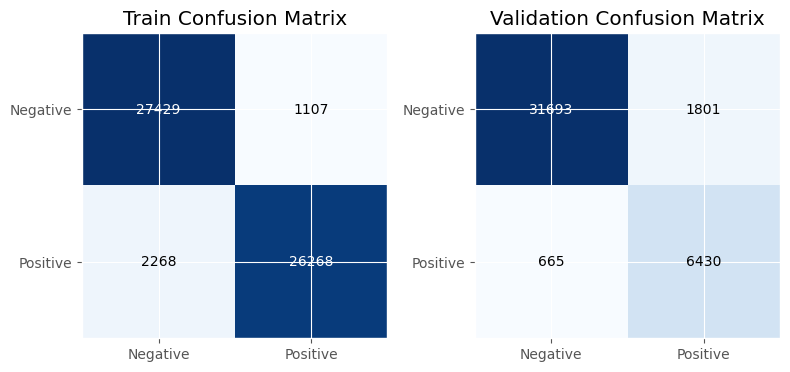

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     28536
           1       0.96      0.92      0.94     28536

    accuracy                           0.94     57072
   macro avg       0.94      0.94      0.94     57072
weighted avg       0.94      0.94      0.94     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     33494
           1       0.78      0.91      0.84      7095

    accuracy                           0.94     40589
   macro avg       0.88      0.93      0.90     40589
weighted avg       0.94      0.94      0.94     40589



In [59]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_Random_Forest_Tuning_CM.png")

In [60]:
print("Random Tree")
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Random Tree
Training Set:
F1 Score: 0.9396362075441327
ROC AUC Score: 0.9887570122275422

Validation Set:
F1 Score: 0.8390969594153725
ROC AUC Score: 0.979864255135911

Root Mean Squared Error : 0.24648605857655698


#### Final Model

In [63]:
logisticRegBase = load("./Model/logisticRegBase.joblib")
logistic_reg_model_tuning = load("./Model/logisticRegBaseWithTuning.joblib")
poly_degree_2_model = load("./Model/logisticRegPoly2WithTuning.joblib")
poly_degree_3_model = load("./Model/logisticRegPoly3WithTuning.joblib")
decision_tree_model = load("./Model/DecisionTreeWithTuning.joblib")
bagged_tree_model = load("./Model/BaggedTreeWithTuning.joblib")
random_forest_model = load("./Model/RandomForestModelWithTuning.joblib")

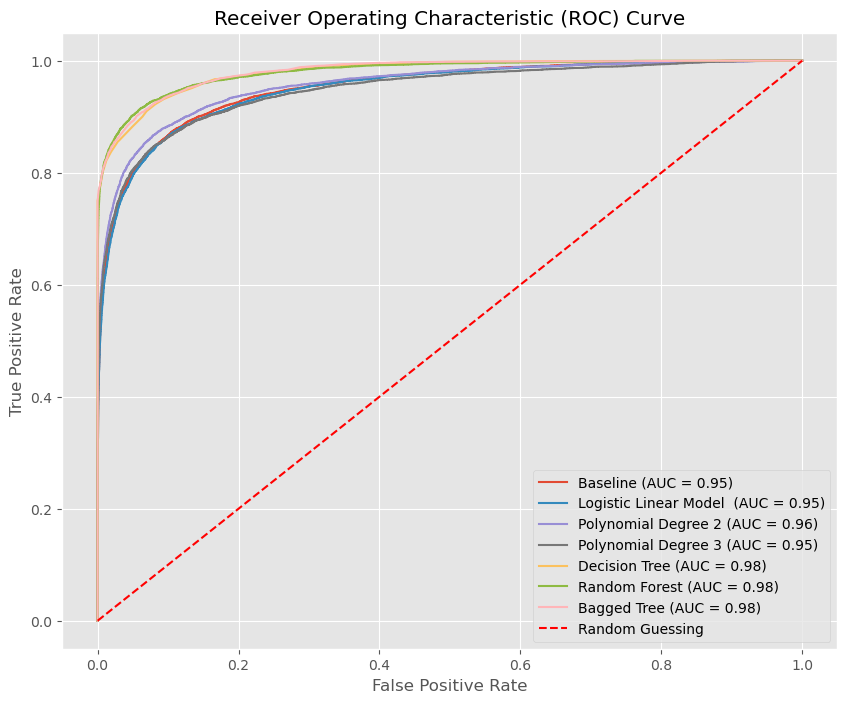

In [66]:
# Initialize figure
plt.figure(figsize=(10, 8))

# Define a list of models and their labels for iteration
models = [logisticRegBase, logistic_reg_model_tuning, poly_degree_2_model, poly_degree_3_model, decision_tree_model, random_forest_model, bagged_tree_model]
model_labels = ['Baseline', 'Logistic Linear Model ', 'Polynomial Degree 2', 'Polynomial Degree 3', 'Decision Tree', 'Random Forest', 'Bagged Tree']

# Plot ROC curves for each model
for model, label in zip(models, model_labels):
    # Predict probabilities
    if label == 'Polynomial Degree 2':
        y_pred_prob = model.predict_proba(val_X_poly2)[:, 1]
        y_pre = model.predict(val_X_poly2)
    elif label == 'Polynomial Degree 3':
        y_pred_prob = model.predict_proba(val_X_poly3)[:, 1]
        y_pre = model.predict(val_X_poly3)
    else:
        y_pred_prob = model.predict_proba(val_x)[:, 1]
        y_pre = model.predict(val_x)
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(val_y, y_pred_prob)
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (label, roc_auc))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("./Image/ROC_curve.png")
# Show plot
plt.show()

In [69]:
from tabulate import tabulate

# Initialize lists to store F1 scores and ROC AUC scores
f1_scores_train = []
roc_auc_scores_train = []
f1_scorers_val = []
roc_auc_scores_val = [] 

# Calculate metrics for each model
for model, label in zip(models, model_labels):
    # Predict probabilities
    if label == 'Polynomial Degree 2':
        y_pred_prob_val = model.predict_proba(val_X_poly2)[:, 1]
        y_pred_prob_train = model.predict_proba(train_x_poly2)[:, 1]
        val_y_pred = model.predict(val_X_poly2)
        train_y_pred = model.predict(train_x_poly2)
    elif label == 'Polynomial Degree 3':
        y_pred_prob = model.predict_proba(val_X_poly3)[:, 1]
        y_pred_prob_train = model.predict_proba(train_x_poly3)[:, 1]
        val_y_pred = model.predict(val_X_poly3)
        train_y_pred = model.predict(train_x_poly3)
    else:
        y_pred_prob = model.predict_proba(val_x)[:, 1]
        y_pred_prob_train = model.predict_proba(train_x_balanced)[:, 1]
        val_y_pred = model.predict(val_x)
        train_y_pred = model.predict(train_x_balanced)
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(val_y, y_pred_prob)
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    # Calculate F1 score
    f1_val= f1_score(val_y, val_y_pred)
    f1_train= f1_score(train_y_balanced, train_y_pred)
    f1_scores_train.append(f1_train)
    f1_scorers_val.append(f1_val)
    # Calculate ROC AUC score
    roc_auc_val= roc_auc_score(val_y, y_pred_prob)
    roc_auc_train = roc_auc_score(train_y_balanced, y_pred_prob_train)
    roc_auc_scores_train.append(roc_auc_train)
    roc_auc_scores_val.append(roc_auc_val)
# Create a DataFrame to store model metrics
metrics_df = pd.DataFrame({
    'Model': model_labels,
    'F1 Score Train': f1_scores_train,
    'F1 Score Validation' : f1_scorers_val,
    'ROC AUC Train Score': roc_auc_scores_train,
    'ROC AUC Validation ' : roc_auc_scores_val
})
# Print the DataFrame in tabular format
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))

+----+-----------------------+------------------+-----------------------+-----------------------+-----------------------+
|    | Model                 |   F1 Score Train |   F1 Score Validation |   ROC AUC Train Score |   ROC AUC Validation  |
+====+=======================+==================+=======================+=======================+=======================+
|  0 | Baseline              |         0.878855 |              0.729142 |              0.950454 |              0.951905 |
+----+-----------------------+------------------+-----------------------+-----------------------+-----------------------+
|  1 | Logistic Linear Model |         0.876588 |              0.727028 |              0.948842 |              0.950215 |
+----+-----------------------+------------------+-----------------------+-----------------------+-----------------------+
|  2 | Polynomial Degree 2   |         0.890366 |              0.755903 |              0.95607  |              0.950215 |
+----+------------------

## Final Model: Optimization

In [70]:
decision_tree_params = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
}

In [71]:
base_tree = DecisionTreeClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0  # Reproducible result
)

In [72]:
decision_tree_clf = GridSearchCV(base_tree, decision_tree_params, scoring=["f1", "roc_auc"], refit="f1",return_train_score=True,n_jobs=-2)

In [73]:
decision_tree_clf.fit(train_x_balanced, train_y_balanced.values.ravel())

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-2,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                         'min_samples_split': array([2, 4, 6, 8])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [74]:
bagged_trees_params = {
    "n_estimators": np.arange(10, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}

base_clf_trees = BaggingClassifier(
    estimator=decision_tree_clf.best_estimator_,
    random_state=0, # Reproducible result
    n_jobs=-2
)

In [75]:
trees_clf = GridSearchCV(
    base_clf_trees,
    bagged_trees_params,
    scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-2
)
trees_clf.fit(train_x_balanced, train_y_balanced.values.ravel())

GridSearchCV(estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                          max_depth=8,
                                                                          random_state=0),
                                         n_jobs=-2, random_state=0),
             n_jobs=-2,
             param_grid={'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'n_estimators': array([10, 15, 20])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [76]:
dump(trees_clf, "./Model/FinalBaggedTreeOptimization.joblib")
print("Model saved successfully.")

Model saved successfully.


In [77]:
model = load("./Model/FinalBaggedTreeOptimization.joblib")
# Predict Value
train_pred_y = model.predict(train_x_balanced)
val_pred_y = model.predict(val_x)

train_proba_pred_y = model.predict_proba(train_x_balanced)[:, 1]
val_proba_pred_y= model.predict_proba(val_x)[:, 1]

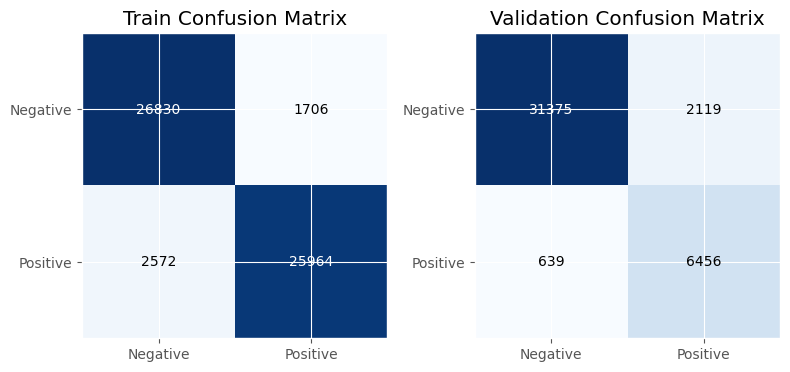

TRAINING PERFORMANCE
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     28536
           1       0.94      0.91      0.92     28536

    accuracy                           0.93     57072
   macro avg       0.93      0.93      0.93     57072
weighted avg       0.93      0.93      0.93     57072

VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     33494
           1       0.75      0.91      0.82      7095

    accuracy                           0.93     40589
   macro avg       0.87      0.92      0.89     40589
weighted avg       0.94      0.93      0.93     40589



In [78]:
plot_confusion_matrices(train_y_balanced, train_pred_y, val_y, val_pred_y, "Model Performance\nLogistic Regression - Linear_Tuning", "./Image/ModelDev_Final_Bagged_Tree.png")

In [79]:
print("Final Bagged Tree")
print_evaluation_metrics(train_y_balanced,train_pred_y,val_y,val_pred_y,train_proba_pred_y,val_proba_pred_y)
rmse = math.sqrt(mean_squared_error(val_y, val_pred_y))
print('\nRoot Mean Squared Error : '+ str(rmse))

Final Bagged Tree
Training Set:
F1 Score: 0.9238871294879551
ROC AUC Score: 0.9821870805739683

Validation Set:
F1 Score: 0.8239948947032546
ROC AUC Score: 0.981052714920426

Root Mean Squared Error : 0.2606711423053137


### Predicting Stage

In [80]:
df_test = pd.read_csv("./data_test.csv", delimiter = ',')
patientID = df_test["Id"].values

In [81]:
testX = df_test.drop(["Id", "Status"], axis =1)

In [82]:
columns_to_drop = ['Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare','NoDocbcCost', 'Sex']
# Drop columns with correlation values insinde the threshold range
testX.drop(columns=columns_to_drop, inplace=True)
testX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50736 entries, 0 to 50735
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   HighBP                50736 non-null  int64
 1   HighChol              50736 non-null  int64
 2   CholCheck             50736 non-null  int64
 3   BMI                   50736 non-null  int64
 4   Smoker                50736 non-null  int64
 5   Stroke                50736 non-null  int64
 6   HeartDiseaseorAttack  50736 non-null  int64
 7   PhysActivity          50736 non-null  int64
 8   GenHlth               50736 non-null  int64
 9   MentHlth              50736 non-null  int64
 10  PhysHlth              50736 non-null  int64
 11  DiffWalk              50736 non-null  int64
 12  Age                   50736 non-null  int64
 13  Education             50736 non-null  int64
 14  Income                50736 non-null  int64
 15  ExtraMedTest          50736 non-null  int64
 16  Extr

In [83]:
from sklearn.preprocessing import PowerTransformer
# Columns to be scaled
columns_to_scale = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'ExtraMedTest', 'ExtraAlcoholTest']

powerTransformer = PowerTransformer(method='yeo-johnson', standardize= False)
train_x[columns_to_scale] = powerTransformer.fit_transform(train_x[columns_to_scale])
testX[columns_to_scale] = powerTransformer.transform(testX[columns_to_scale])

In [86]:
bagged_tree_model = load("./Model/FinalBaggedTreeOptimization.joblib")

In [87]:
pred_y = bagged_tree_model.predict(testX)

In [89]:
df_export = pd.DataFrame({"Id": patientID, "Status": pred_y})

In [90]:
df_export.to_csv("./COSC_A1_Prediction_S3929215.csv", index=False)